Deep Learning Udacity - Assignment 1
=============

This notebook downloads the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset, which is similar to the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, but contains more realistic data.

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

The next block downloads the dataset to the local machine. 
notMNIST data consists of characters rendered in a variety of fonts on a 28x28 image. 
Labels are limited to  10 classes, with a training set of 500k examples, and a test set of 19000 labelled examples.

In [4]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Download Path for noMNIST

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_small.tar.gz


Perform the extraction of the dataset from the compressed file if not present.

In [5]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


---
Problem 1
---------

Display a sample of the images that we just downloaded.

In [32]:
display(Image(filename="notMNIST_small/A/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))

Before loading the dataset, we are going to check the available ram of the computer

In [8]:
# Check the amount of ram available in your machine
import psutil # Windows system
psutil.virtual_memory()

#import os  # Unix system
#mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')  
#mem_bytes/(1024.**3)

svmem(total=17120362496, available=5708259328, percent=66.7, used=11412103168, free=5708259328)

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [9]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling .\notMNIST_large\A.pickle.
.\notMNIST_large\A
Could not read: .\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file '.\\notMNIST_large\\A\\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: .\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file '.\\notMNIST_large\\A\\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: .\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : cannot identify image file '.\\notMNIST_large\\A\\Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling .\notMNIST_large\B.pickle.
.\notMNIST_large\B
Could not read: .\notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file '.\\notMNIST_large\\B\\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. 

---
We have to load one of the pickled dataset files

In [26]:
train_datasets

['.\\notMNIST_large\\A.pickle',
 '.\\notMNIST_large\\B.pickle',
 '.\\notMNIST_large\\C.pickle',
 '.\\notMNIST_large\\D.pickle',
 '.\\notMNIST_large\\E.pickle',
 '.\\notMNIST_large\\F.pickle',
 '.\\notMNIST_large\\G.pickle',
 '.\\notMNIST_large\\H.pickle',
 '.\\notMNIST_large\\I.pickle',
 '.\\notMNIST_large\\J.pickle']

In [30]:
file = open(train_datasets[2], 'rb')
train_C = pickle.load(file)
print(train_A.shape)

(52912, 28, 28)


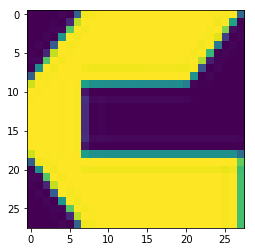

In [29]:
plt.imshow(train_A[0,:,:])

---
Problem 3
---------
Verify the data is balanced across classes. 

---

In [33]:
print('Check images per class','...')
for letter in train_datasets:
    file = open(letter, 'rb')
    dataset = pickle.load(file)
    print(letter + ' size: ' + str(dataset.shape[0]))
for letter in test_datasets:
    file = open(letter, 'rb')
    dataset = pickle.load(file)
    print(letter + ' size: ' + str(dataset.shape[0]))

Check images per class ...
.\notMNIST_large\A.pickle size: 52909
.\notMNIST_large\B.pickle size: 52911
.\notMNIST_large\C.pickle size: 52912
.\notMNIST_large\D.pickle size: 52911
.\notMNIST_large\E.pickle size: 52912
.\notMNIST_large\F.pickle size: 52912
.\notMNIST_large\G.pickle size: 52912
.\notMNIST_large\H.pickle size: 52912
.\notMNIST_large\I.pickle size: 52912
.\notMNIST_large\J.pickle size: 52911
.\notMNIST_small\A.pickle size: 1872
.\notMNIST_small\B.pickle size: 1873
.\notMNIST_small\C.pickle size: 1873
.\notMNIST_small\D.pickle size: 1873
.\notMNIST_small\E.pickle size: 1873
.\notMNIST_small\F.pickle size: 1872
.\notMNIST_small\G.pickle size: 1872
.\notMNIST_small\H.pickle size: 1872
.\notMNIST_small\I.pickle size: 1872
.\notMNIST_small\J.pickle size: 1872


Merge and prune the training data as needed. Labels will be stored into a separate array of integers 0 through 9.

Then create a validation dataset for hyperparameter tuning.

In [34]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [35]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Verify data is still balanced after shuffling!

---

In [37]:
print(np.unique(train_labels))
print(np.unique(test_labels))
print(np.bincount(train_labels))
print(np.bincount(test_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[20000 20000 20000 20000 20000 20000 20000 20000 20000 20000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


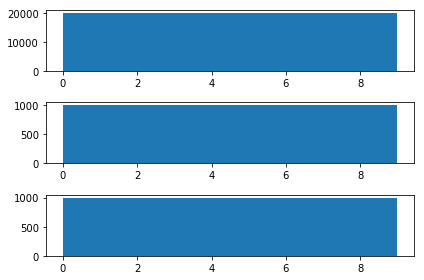

In [36]:
#Visualize the same information
fig, ax = plt.subplots(3, 1)
ax[0].hist(train_labels, 10)
ax[1].hist(test_labels, 10)
ax[2].hist(valid_labels, 10)
fig.tight_layout()

Finally, let's save the data for later reuse:

In [68]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [39]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [64]:
def unique_rows(a):
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

(samples, width, height) = train_dataset.shape
unique_td = unique_rows(np.reshape(train_dataset,(samples, width * height)))
print('Duplicates inside training set: ', len(train_dataset) - len(unique_td))

Duplicates inside training set:  12783


In [56]:
#More stylish solution, using hash 
train_dataset.flags.writeable = False
valid_dataset.flags.writeable = False
test_dataset.flags.writeable = False

train_hash = [hash(e.tobytes()) for e in train_dataset]
valid_hash = [hash(e.tobytes()) for e in valid_dataset]
test_hash = [hash(e.tobytes()) for e in test_dataset]

unique_train_hash = set(train_hash)
valid_overlap = unique_train_hash.intersection(set(valid_hash))
test_overlap = unique_train_hash.intersection(set(test_hash))

print('Duplicates inside training set: ', len(train_hash) - len(unique_train_hash))
print('Duplicates between training and validation: ', len(valid_overlap))
print('Duplicates between training and test: ', len(test_overlap))

Duplicates inside training set:  12783
Duplicates between training and validation:  953
Duplicates between training and test:  1153


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [67]:
from sklearn.linear_model import LogisticRegression

train_sample = train_dataset[:500,:,:]
train_sample_l = train_labels[:500]

(samples, width, height) = train_sample.shape
train_sample = np.reshape(train_sample, (samples, width * height))

(samples, width, height) = test_dataset.shape
test_dataset_r= np.reshape(test_dataset, (samples, width * height))

model = LogisticRegression(penalty='l2', C=1.0)
model.fit(train_sample, train_sample_l)

train_acc = model.score(train_sample, train_sample_l)
test_acc = model.score(test_dataset_r, test_labels)

print('Training accuracy: ', train_acc)
print('Test accuracys:', test_acc)

Training accuracy:  1.0
Test accuracys: 0.8331
